1. **Definitions**:
    - Let $ s_t $ represent the image frame at time step $ t $.
    - Let $ s_{t+k} $ represent the image frame at time step $ t+k $, which is $ k $ time steps after $ s_t $.
2. **Problem Statement**:
    - **a)** Compute the geodesic distance between $ s_t $ and $ s_{t+k} $ in a suitable image embedding space.
    - **b)** Sample intermediate image frames that lie on the geodesic path between $ s_t $ and $ s_{t+k} $.

3. **Proposed Solution**:
    - **a)** Using a pretrained network's second-to-last layer as an embedding space, as embedding should meaningfully capture the content of the images due to the network's prior training on a potentially large and diverse dataset
    - **b)** Intermediate Frames:
        - i) interpolate and generate intermediate frames by gradient-based optimization w.r.t. target image in pixel space (Note: could be computationally intensive and might not always produce visually coherent transitions, especially if $ s_{\text{start}} $ and $ s_{\text{target}} $ are substantially different).
        - ii) Image morphing techniques
        - iii) Variational Autoencodes (VAE)
        - iv) Manifold Learning
        - v) fine-tune model and then do i)


4. **Mathematical Formulation**:
    - Let $ f $ be a neural network function that maps an image to a lower-dimensional embedding space, i.e., $ f: \mathcal{I} \rightarrow \mathbb{R}^d $ where $ \mathcal{I} $ is the space of images.
    - Define the geodesic distance $ d $ between  $s_t$  and $s_{t+k}$ as $ d(s_t, s_{t+k}) = \| f(s_t) - f(s_{t+k}) \| $, where $ \| \cdot \| $ denotes the Euclidean norm.
    - Intermediate frames  $s_{t+i}$  for $ i = 1, 2, \ldots, k-1 $ are generated by $ s_{t+i} = g(\theta_{t+i}) $, where $ \theta_{t+i} $ is a parameter vector obtained by interpolating between parameters representing $ s_t $ and $ s_{t+k} $ in the embedding space.

In [16]:
import numpy as np
import matplotlib.pyplot as plt
# so that relative sizes of axes created by po.imshow and others look right
plt.rcParams['figure.dpi'] = 72
%matplotlib inline

import pyrtools as pt
import plenoptic as po
from plenoptic.tools import to_numpy
%load_ext autoreload
%autoreload 2

from PIL import Image

import copy

import torch
torch.manual_seed(17)
import torch.nn as nn
# this notebook uses torchvision, which is an optional dependency.
# if this fails, install torchvision in your plenoptic environment 
# and restart the notebook kernel.
try:
    import torchvision
except ModuleNotFoundError:
    raise ModuleNotFoundError("optional dependency torchvision not found!"
                              " please install it in your plenoptic environment "
                              "and restart the notebook kernel")
import torchvision.transforms as transforms
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype  = torch.float32
torch.__version__

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'2.3.1+cu121'

## Load test images


In [8]:
einstein = po.data.einstein()
# display the image of the tensor
# po.imshow(einstein)
# parrot = po.data.parrot()
# print(parrot.shape)

# load the image parrot.png
image_path = '../src/plenoptic/data/'
start_image_parrot = Image.open(image_path + 'parrot.png')
# image to tensor 
start_image_t_parrot = transforms.ToTensor()(start_image_parrot)
target_image_t_parrot = transforms.RandomRotation(degrees=45)(start_image_t_parrot)
# display the rotated target image
transforms.ToPILImage()(target_image_t_parrot)
start_image_t_parrot


tensor([[[0.3333, 0.3333, 0.3373,  ..., 0.3843, 0.3765, 0.3843],
         [0.3412, 0.3333, 0.3451,  ..., 0.3765, 0.3686, 0.3686],
         [0.3255, 0.3255, 0.3333,  ..., 0.3765, 0.3686, 0.3569],
         ...,
         [0.3333, 0.3373, 0.3333,  ..., 0.4471, 0.4549, 0.4549],
         [0.3333, 0.3373, 0.3373,  ..., 0.4588, 0.4510, 0.4471],
         [0.3373, 0.3294, 0.3333,  ..., 0.4588, 0.4510, 0.4588]]])

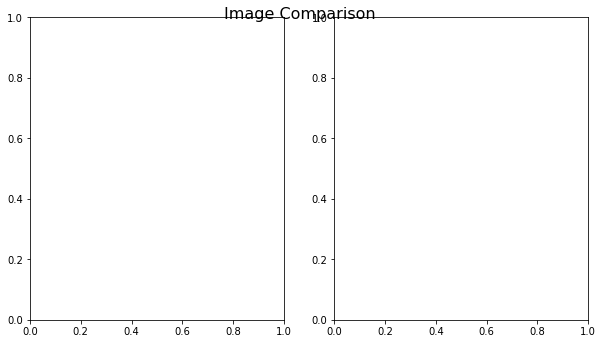

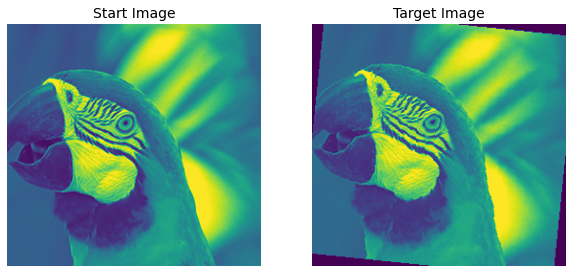

In [9]:

def display_image_pairs(image_pairs):
    """
    Display pairs of images in rows with labels.

    Args:
    image_pairs (list of tuples): List of tuples where each tuple contains two images as tensors.
    """
    # Convert tensor to PIL image
    to_pil = transforms.ToPILImage()

    # Number of image pairs
    num_pairs = len(image_pairs)


    # Create a matplotlib figure
    fig, axes = plt.subplots(num_pairs, 2, figsize=(10, 5 * num_pairs))

    # Set the column titles
    fig.suptitle('Image Comparison', fontsize=16)
    fig.subplots_adjust(top=0.95)  # Adjust the top to make room for the title

    # Handle the case for a single pair differently to avoid indexing issues
    if num_pairs == 1:
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes = [axes]  # Make axes a list of lists to handle it uniformly later
    else:
        fig, axes = plt.subplots(num_pairs, 2, figsize=(10, 5 * num_pairs))

    
    # Set column labels
    if num_pairs == 1:
        axes[0][0].set_title('Start Image', fontsize=14)
        axes[0][1].set_title('Target Image', fontsize=14)
    else:
        axes[0, 0].set_title('Start Image', fontsize=14)
        axes[0, 1].set_title('Target Image', fontsize=14)


        # Display each pair of images
    for i, (start_image, target_image) in enumerate(image_pairs):
        # Convert tensors to PIL images
        start_image_pil = to_pil(start_image)
        target_image_pil = to_pil(target_image)

        # Display the start image
        axes[i][0].imshow(start_image_pil)
        axes[i][0].axis('off')  # Turn off axis
        # Display the target image
        axes[i][1].imshow(target_image_pil)
        axes[i][1].axis('off')  # Turn off axis
        

    # Show the plot
    plt.show()

# List of pairs of images
image_pairs = [(start_image_t_parrot, target_image_t_parrot)]
display_image_pairs(image_pairs)


## Loading Pretrained Model

We download a pretrained model from  [ImageNet torchvision.models](https://pytorch.org/vision/stable/models.html). As ImageNet models have learned to detect animals, including parrots, it might be especially well suited for embedding different parrots in an interpreteble way, i.e, close to each other in embedding space.



In [13]:
from torchvision.models import vgg16
from torchvision.models import VGG16_Weights

# load the VGG16 network as used in the paper 
weights = VGG16_Weights.DEFAULT
vgg_model_original = vgg16(weights=weights)
vgg_model_original.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### Freezing the base model and cutting of the final layer

In [14]:
vgg_model_original.requires_grad_(False)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### Dropping the final layer
We don't want to classify our images, so let's drop the final layer by replacing it with an identity identity

In [15]:
# copy the vgg model and remove the last layer
vgg_model = vgg_model_original.copy()


AttributeError: 'VGG' object has no attribute 'copy'